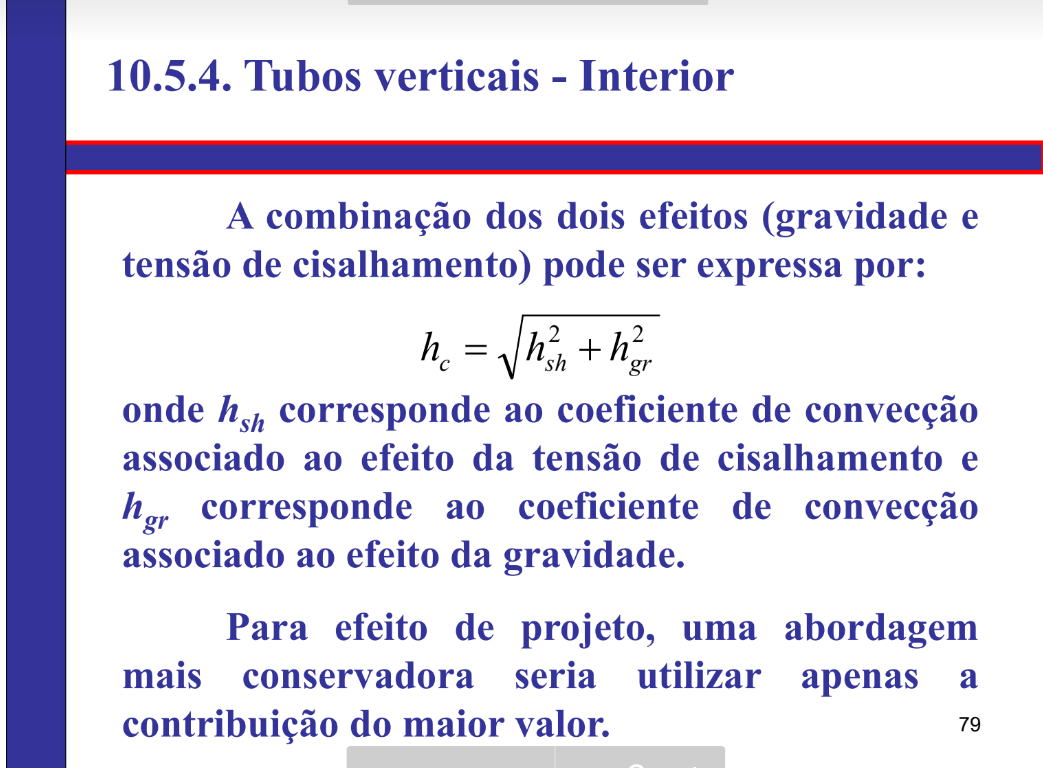

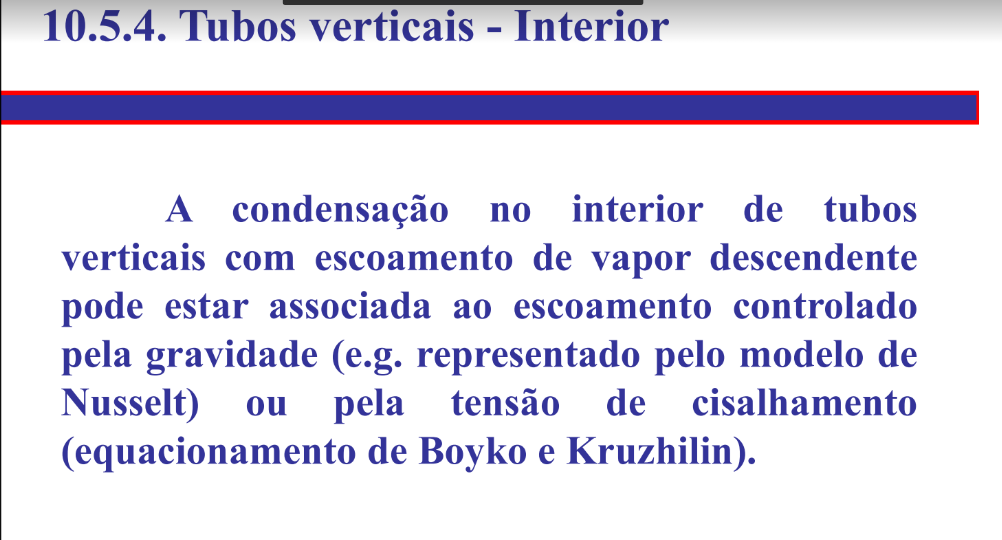

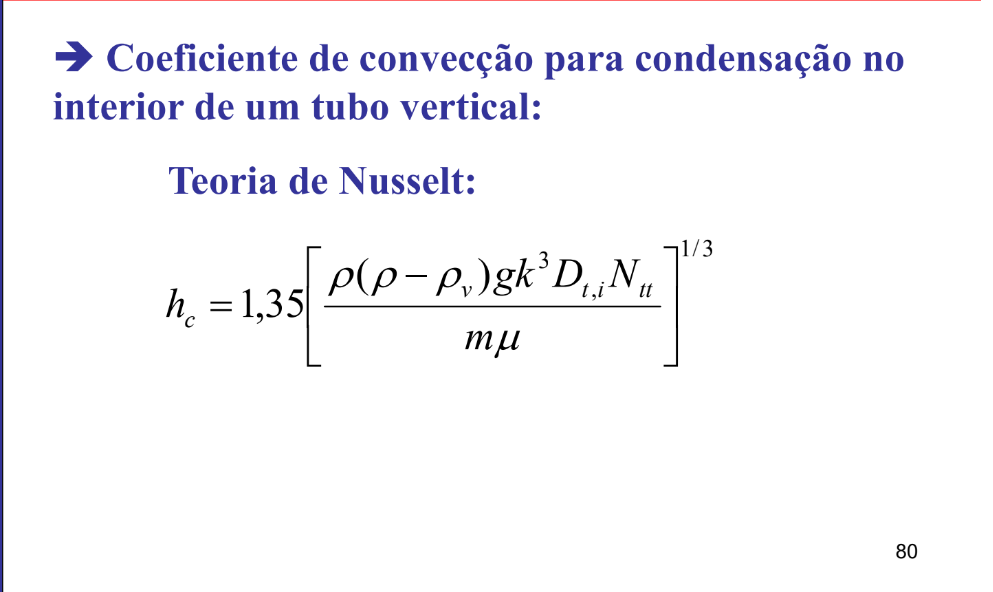

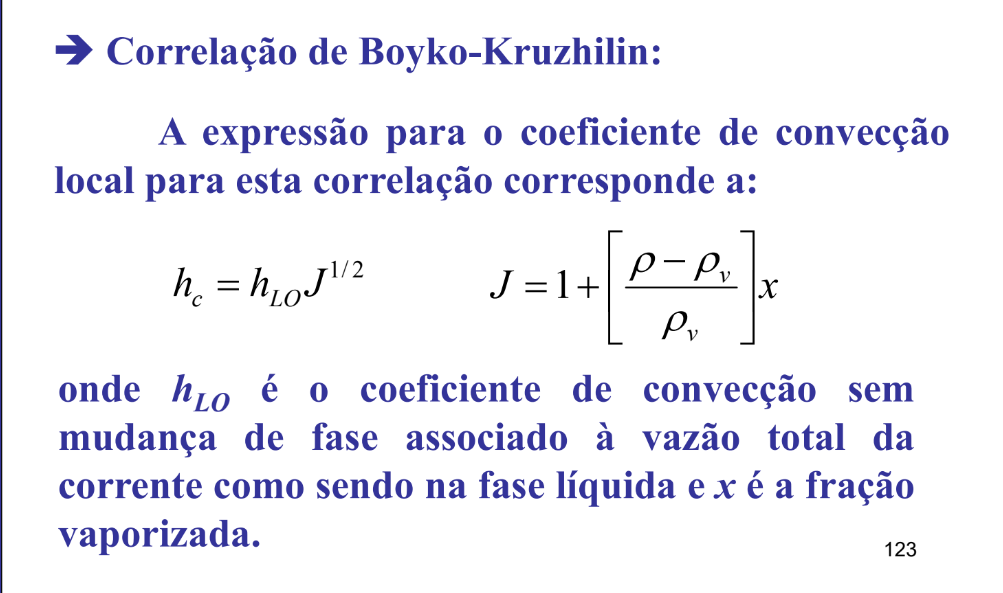

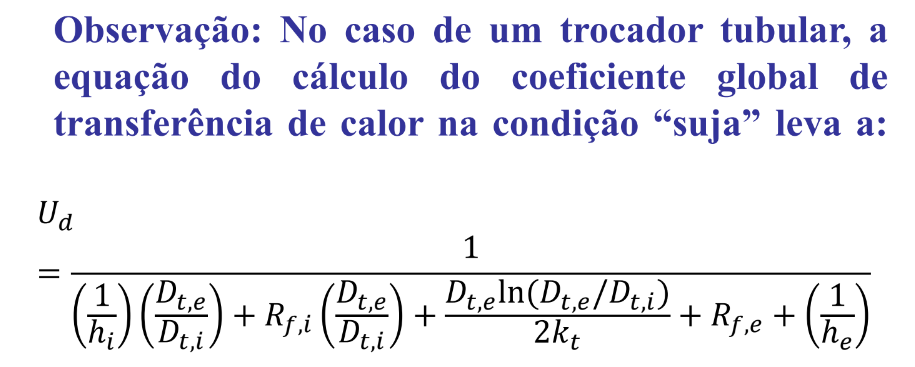

$$U_e = \frac{1}{\frac{1}{h_e}+R_{f,e}+\frac{D_{t,e} \cdot Ln(\frac{D_{t,e}}{D_{t,i}})}{2k_t} + R_{f,i} \cdot (\frac{D_{t,e}}{D_{t,i}}) + \bar{h_c} \cdot (\frac{D_{t,e}}{D_{t,i}})
}$$

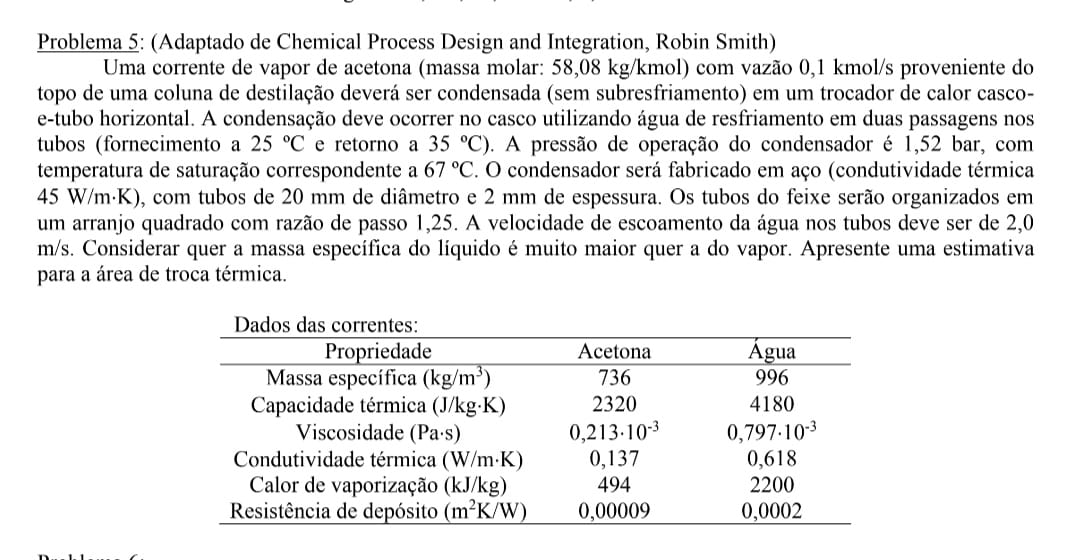

Vamos fazer adaptações nesse problema para a princípio simplifica-lo:


*   Passo 1-1
*   Cond vertical
*   Amônia nos tubos(desc)
*   ContraCorrente
*   Tamanho, espessura e número de tubos







In [208]:
from typing import Optional
import numpy as np
import sympy as sp
from scipy import integrate
import plotly.express as px

In [209]:
#Tubos 3/4 in
#bwg 16
#Passe no tubo 1 inch = 0.0254 m
#Arranjo quadrado
Ltp = 0.0254
F = 5.808 # kg /s
DeltaHvap_Acetona = 494000 #J/kg
Cp_h2o = 4180 # J/kg
Cp_Ac = 2320 # J/kg
Rfe = 0.0002
Rfi = 0.00009
DeltaT_H2o = 10 #Entra em 25 sai em 35
T_sat = 67 # °C
Rho_ac = 736 #kg/m^3
Rho_h2o = 996 #kg/m^3
mi_ac = 0.213e-3 # Pa*s
mi_h2o = 0.797e-3
k_ac = 0.137 # W/(mK)
k_h2o = 0.618
k_t = 45
Ntp = Ntt = 80
Ds = 0.3048 # m
De = 0.01905 #m
Di = De - 2*0.00165 #m

In [210]:
#https://www.engineeringtoolbox.com/acetone-2-propanone-density-specific-weight-temperature-pressure-d_2038.html?vA=67&degree=C#
Rho_ac_V = 2.170 #kg/m^3

In [211]:
def vel_tubos(F,di,rho,Ntp):
  A_um_tubo = np.pi*di**2/4
  vel = (F/rho)/(Ntp*A_um_tubo)
  return vel
def Re(vel,mi,di,rho):
  Re = rho*vel*di/mi
  return Re
def Pr(cp,mi,k):
  Pr = cp*mi/k
  return Pr
def f(Re):
  if Re <= 1311:
    f = 64/Re
  elif Re < 3380:
    f = 0.0488
  else:
    f = 0.014 + 1.056/Re**0.42
  return f
def Nu(Re,f,Pr):
  Nu = (f/8)*(Re-1000)*Pr/(1+12.7*((f/8)**0.5)*(-1+Pr**(2/3)))
  return Nu
def h(Nu,k,di):
  h = Nu*k/di
  return h


Cálculo do coeficiente de película do casco

In [212]:
# Espaçamento entre chicanas = 50%Ds
Lbc = 0.50*Ds
A_esc_casco = Ds*(Ltp-De)*Lbc/Ltp
Deq = 4*Ltp**2/(np.pi*De) - De
m_h2o =(F*DeltaHvap_Acetona/(Cp_h2o*DeltaT_H2o))
Vel_casco = (m_h2o/Rho_h2o)/A_esc_casco
Re_casco = Re(Vel_casco,mi_h2o,Deq,Rho_h2o)
Pr_casco = Pr(Cp_h2o,mi_h2o,k_h2o)
f_at = f(Re_casco)
Nu_casco = 0.36*Re_casco**0.55*Pr_casco**(1/3)
h_casco = h(Nu_casco,k_h2o,Deq)
Vel_casco,h_casco


(5.9344161526341805, 12534.417523061154)

Velocidade muito alta pro casco, a pressão não suportaria, mas vou prosseguir para motivos didáticos

Cálculo do coeficiente de película dos tubos sem mudança de fase associado a vazão total da corrente

In [213]:
v_tubos = vel_tubos(F,Di,Rho_ac,Ntp)
Re_tub = Re(v_tubos,mi_ac,Di,Rho_ac)
Pr_tubos = Pr(Cp_Ac,mi_ac,k_ac)
f_at_tub = f(Re_tub)
Nu_tub = Nu(Re_tub,f_at_tub,Pr_tubos)
h_LO = h(Nu_tub,k_ac,Di)
v_tubos, h_LO

(0.5062998616877147, 1462.5388867828824)

In [214]:
def hc_med(Rho_L,Rho_V,h_LO,k_t,D_ti,m,mi,Ntt,x):
# def hc_med(Rho_L,Rho_V,h_LO,x):
  h_nusselt = 1.35*(Rho_ac*(Rho_ac-Rho_ac_V)*9.81*k_ac**3*Di*Ntt/(F*mi_ac))**(1/3)
  
  h_Boyko_Khruzhilin = h_LO*(1+(Rho_L-Rho_V)*x/Rho_V)**0.5
  return (h_nusselt**2 + h_Boyko_Khruzhilin**2)**0.5
  # return h_Boyko_Khruzhilin

In [215]:
def Ue(hc_med,he,di,de,k,Rfe: Optional[int] = 0,Rfi: Optional[int] = 0) -> float:
  Ue = ((de/di)*(1/hc_med) + de*np.log(de/di)/(2*k) +(1/he) +(de/di)*Rfi + Rfe )**-1
  return Ue

In [216]:
def Deltax(Q,DeltaH_vap,m_tot):
  m = Q/DeltaH_vap
  Deltax = (Q/DeltaH_vap)/m_tot
  return Deltax

In [217]:
Deltax(2.87e6,DeltaHvap_Acetona,F)

1.0002955577118255

$$Q_{j+1}-Q_j = U_j\cdot ΔT_j \cdot Ntt \cdot  (\pi D_{t,e})(L_{j+1}-L_j)$$

In [218]:
#ToDo 
'''Chutar L e rodar até convergir,
se ao convergir não atingir Qtot, aumentar L
'''


'Chutar L e rodar até convergir,\nse ao convergir não atingir Qtot, aumentar L\n'

In [219]:
#ToDo
def f_der_mod(z, y, m_h2o,Cp_h2o,DeltaHvap_Acetona,F,T_sat,Rho_ac,Rho_ac_V,h_LO,
              h_casco,Di,De,k_t,Rfi,Rfe,Ntt):
  #
  Q = y[0]
  #T_h2o é a temperatura que chutamos para começar a iteração, pois só sabemos a T_h2o_out:
  T_h2o = y[1]
  x = y[2]
  #
  nvd = y.shape[0]
  #
  hc = hc_med(Rho_ac,Rho_ac_V,h_LO,x)
  U = Ue(hc,h_casco,Di,De,k_t,Rfe,Rfi)


  if Q == 0:
    deltax = - Deltax(U * (T_sat - T_h2o),DeltaHvap_Acetona,F)
  else:
    deltax = - Deltax(Q,DeltaHvap_Acetona,F)
  #
  dydz = np.zeros((nvd,))
  #
  #dydz[0] é Q
  #dydz[1] é T_h2o
  dydz[0] = U * (T_sat - T_h2o)*np.pi*De*Ntt
  dydz[1] = Q/(m_h2o*Cp_h2o)
  dydz[2] = deltax
  # dQdz[1] = (1/par[1]) * (par[3]*h1**0.5 - (par[5] + par[4]*h2))
  #
  return(dydz)

In [220]:
z_0 = np.array([0,35,1])
par = np.array([m_h2o,Cp_h2o,DeltaHvap_Acetona,F,T_sat,Rho_ac,Rho_ac_V,h_LO,
              h_casco,Di,De,k_t,Rfe,Rfi,Ntt,k_ac,mi_ac])
par

array([6.86400000e+01, 4.18000000e+03, 4.94000000e+05, 5.80800000e+00,
       6.70000000e+01, 7.36000000e+02, 2.17000000e+00, 1.46253889e+03,
       1.25344175e+04, 1.57500000e-02, 1.90500000e-02, 4.50000000e+01,
       2.00000000e-04, 9.00000000e-05, 8.00000000e+01, 1.37000000e-01,
       2.13000000e-04])

In [221]:
def f_der_mod(z, y, par):
  #
  Q = y[0]
  #T_h2o é a temperatura que chutamos para começar a iteração, pois só sabemos a T_h2o_out:
  T_h2o = y[1]
  x = y[2]
  #
  nvd = y.shape[0]
  #
  hc = hc_med(par[5],par[6],par[7],par[15],par[9],par[3],par[16],par[14],x)
  U = Ue(hc,par[8],par[9],par[10],par[11],par[12],par[13])


  if Q == 0:
    # deltax = - Deltax(U * (par[4] - T_h2o)*np.pi*par[10],par[2],par[3])
    deltax = 0
  else:
    deltax = - Deltax(Q,DeltaHvap_Acetona,F)
  if x<1.0e-4:
    print(f'O comprimento que condensa toda a corrente é: {z}')
  #
  dydz = np.zeros((nvd,))
  #
  #dydz[0] é Q
  #dydz[1] é T_h2o
  dydz[0] = U * (T_sat - T_h2o)*np.pi*par[10]*par[14]
  dydz[1] = -Q/(par[0]*par[1])
  dydz[2] = deltax
  # dQdz[1] = (1/par[1]) * (par[3]*h1**0.5 - (par[5] + par[4]*h2))
  #
  return(dydz)

In [222]:
z_sim = 3.0 # m ; trocadores chegam no máximo a 6m, porém é grosseria para um condensador
z_span = (0, z_sim)
z_vetor = np.linspace(0,z_sim,200)
z_vetor[1]

0.01507537688442211

In [223]:
par = np.array([m_h2o,Cp_h2o,DeltaHvap_Acetona,F,T_sat,Rho_ac,Rho_ac_V,h_LO,
              h_casco,Di,De,k_t,Rfe,Rfi,Ntt,k_ac,mi_ac])
# hc_med(Rho_L,Rho_V,h_LO,k_t,D_ti,m,mi,Ntt,x)
hc = hc_med(par[5],par[6],par[7],par[15],par[9],par[3],par[16],par[14],1)
U = Ue(hc,par[8],par[9],par[10],par[11],par[12],par[13])
U

2110.5764115959732

In [224]:
f_der_mod(0,z_0,par)

array([323359.70357289,      0.        ,      0.        ])

In [225]:
sol = integrate.solve_ivp(f_der_mod, z_span, z_0, method = 'LSODA',
                          t_eval=z_vetor, args = (par,), atol= 1.0e-10)

In [226]:
sol.y[1]

array([35.        , 34.99978825, 34.99849355, 34.99646166, 34.99442977,
       34.99239788, 34.99036599, 34.98833411, 34.98090696, 34.97872907,
       34.97629479, 34.97360412, 34.97065706, 34.96745361, 34.96399377,
       34.9602771 , 34.95630363, 34.95207363, 34.94758712, 34.94284408,
       34.93784452, 34.93258844, 34.92707584, 34.92130672, 34.91528108,
       34.90899892, 34.90245864, 34.89566094, 34.88860635, 34.88129486,
       34.87372648, 34.8659012 , 34.85781902, 34.84947995, 34.84088399,
       34.83203113, 34.82292137, 34.81356055, 34.8039306 , 34.79404364,
       34.78389963, 34.77349852, 34.76284025, 34.75192477, 34.74075201,
       34.72932194, 34.71763449, 34.70568937, 34.69348108, 34.68101457,
       34.66828976, 34.65530657, 34.64206492, 34.62856474, 34.61480594,
       34.60078844, 34.58651216, 34.57197702, 34.55718295, 34.54212987,
       34.52681768, 34.51124633, 34.49541571, 34.47932576, 34.4629764 ,
       34.44636754, 34.42949911, 34.41237102, 34.3949832 , 34.37

In [227]:
sol.y[1][-1]
#A corrente fria está entrando a 29°C, não 25°C como queríamos, então vamos precisar extender o trocador

29.80632562124048

In [228]:
sol.y[0][-1]
#O calor total ainda não foi atingido

1010639.2238109891

In [229]:
sol.y[2][-1]
#Condensou pouco mais da metade da corrente

0.4806325621244224

In [230]:
Q_tot = F*DeltaHvap_Acetona
Q_tot

2869152.0

Para alterar a T_cold_out uma vez que acerte T_cold_in, respeitando aproach minimo(10°C):
$$dT = \frac{1}{m_{H2O}*Cp_{H2O}}\cdot dQ$$ 

Em seguida, para alterar L caso não dê energia suficiente:
$$dQ = \bar{U} \cdot ΔT_{lm}\cdot πD_{t,e}N_{tt}\cdot dL$$

In [231]:
sol.y[2]

array([1.        , 0.99997882, 0.99984936, 0.99964617, 0.99944298,
       0.99923979, 0.9990366 , 0.99883341, 0.9980907 , 0.99787291,
       0.99762948, 0.99736041, 0.99706571, 0.99674536, 0.99639938,
       0.99602771, 0.99563036, 0.99520736, 0.99475871, 0.99428441,
       0.99378445, 0.99325884, 0.99270758, 0.99213067, 0.99152811,
       0.99089989, 0.99024586, 0.98956609, 0.98886063, 0.98812949,
       0.98737265, 0.98659012, 0.9857819 , 0.984948  , 0.9840884 ,
       0.98320311, 0.98229214, 0.98135606, 0.98039306, 0.97940436,
       0.97838996, 0.97734985, 0.97628403, 0.97519248, 0.9740752 ,
       0.97293219, 0.97176345, 0.97056894, 0.96934811, 0.96810146,
       0.96682898, 0.96553066, 0.96420649, 0.96285647, 0.96148059,
       0.96007884, 0.95865122, 0.9571977 , 0.9557183 , 0.95421299,
       0.95268177, 0.95112463, 0.94954157, 0.94793258, 0.94629764,
       0.94463675, 0.94294991, 0.9412371 , 0.93949832, 0.93773356,
       0.9359428 , 0.93412605, 0.9322833 , 0.93041421, 0.92851

In [232]:
# Novo chute de T_cold_out será aplicar a diferença da T_cold_in desejada com a in encontrada do chute

In [233]:
z_0 = np.array([0,31,1])
sol = integrate.solve_ivp(f_der_mod, z_span, z_0, method = 'LSODA',
                          t_eval=z_vetor, args = (par,), atol= 1.0e-10)

In [234]:
sol.y[1]

array([31.        , 30.9997707 , 30.9982095 , 30.99617775, 30.994146  ,
       30.99211424, 30.99008249, 30.98805074, 30.98109453, 30.97864446,
       30.97590601, 30.97287919, 30.969564  , 30.96596031, 30.96206763,
       30.95788645, 30.95341678, 30.94865861, 30.94361194, 30.93827677,
       30.93265311, 30.92674095, 30.92054029, 30.91405113, 30.9072721 ,
       30.90020359, 30.89284622, 30.88519999, 30.87726489, 30.86904093,
       30.86052811, 30.85172642, 30.84263587, 30.83325646, 30.82359792,
       30.81363462, 30.80338238, 30.79284116, 30.7820109 , 30.77089154,
       30.75948304, 30.74778532, 30.73579834, 30.72352205, 30.71095638,
       30.69809743, 30.68494644, 30.67150519, 30.6577736 , 30.64375159,
       30.62943908, 30.61483598, 30.59994222, 30.5847577 , 30.56928235,
       30.55351608, 30.53745882, 30.52111048, 30.50447097, 30.48754021,
       30.47031813, 30.45280464, 30.43499966, 30.4169031 , 30.39851488,
       30.37983492, 30.36086314, 30.34159945, 30.32204378, 30.30

In [235]:
sol.y[2][-1]
#ainda condensa apenas 58.5% da corrente, vamos aumentar o comprimento

0.41652470895847793

In [237]:
## ToDo!!
#
#Farei U_méd mais para frente, por enquanto vou usar U(x=0.5)
hc = hc_med(par[5],par[6],par[7],par[15],par[9],par[3],par[16],par[14],0.5)
U = Ue(hc,par[8],par[9],par[10],par[11],par[12],par[13])

dL = (Q_tot-sol.y[0][-1])*(1/(U*np.pi*Ntt*De)     )
dL

178.36999536352496

In [238]:
z_sim = 3.905 # m ; trocadores chegam no máximo a 6m, porém é grosseria para um condensador
z_span = (0, z_sim)
z_vetor = np.linspace(0,z_sim,200)

In [239]:
z_0 = np.array([0,31,1])
sol = integrate.solve_ivp(f_der_mod, z_span, z_0, method = 'LSODA',
                          t_eval=z_vetor, args = (par,), atol= 1.0e-10)

In [240]:
sol.y[1]

array([31.        , 30.99962834, 30.99698368, 30.99433901, 30.99169435,
       30.98904968, 30.98152745, 30.97835297, 30.97468989, 30.97053821,
       30.9658978 , 30.96076792, 30.95514924, 30.94904175, 30.94244544,
       30.93536032, 30.92778639, 30.91972365, 30.91117189, 30.90212866,
       30.892596  , 30.88257391, 30.87206238, 30.86106143, 30.84957104,
       30.83759122, 30.82513267, 30.81216595, 30.79870968, 30.78476374,
       30.77032799, 30.75540231, 30.73998659, 30.7240807 , 30.70768451,
       30.69079057, 30.67340444, 30.65552639, 30.63715625, 30.61829384,
       30.59893896, 30.57909145, 30.55875112, 30.53791778, 30.51659126,
       30.49477138, 30.47245794, 30.44965078, 30.4263497 , 30.40255453,
       30.37826509, 30.35348118, 30.32820264, 30.30242928, 30.27615547,
       30.2493826 , 30.22211303, 30.19434652, 30.16608283, 30.13732171,
       30.10806291, 30.07830619, 30.0480513 , 30.017298  , 29.98604604,
       29.95429519, 29.92204518, 29.88929578, 29.85604675, 29.82

In [241]:
z_0 = np.array([0,35,1])
sol = integrate.solve_ivp(f_der_mod, z_span, z_0, method = 'LSODA',
                          t_eval=z_vetor, args = (par,), atol= 1.0e-10)

In [242]:
sol.y[1]

array([35.        , 34.99967671, 34.99726764, 34.9946228 , 34.99197796,
       34.98933312, 34.98668828, 34.97846996, 34.97521373, 34.97152309,
       34.96739804, 34.96283858, 34.95784376, 34.95241424, 34.94655009,
       34.9402513 , 34.93351788, 34.92634982, 34.91874713, 34.91070981,
       34.90223619, 34.89332627, 34.88398108, 34.87420063, 34.86398491,
       34.85333392, 34.84224766, 34.83072614, 34.8187787 , 34.80637833,
       34.79354255, 34.78027122, 34.76656424, 34.75242149, 34.73784284,
       34.72282818, 34.70737739, 34.69148316, 34.67515086, 34.65838085,
       34.64117296, 34.623527  , 34.60544282, 34.58692022, 34.56795903,
       34.54855908, 34.5287202 , 34.5084422 , 34.48772491, 34.46656815,
       34.44497175, 34.42293554, 34.40045933, 34.37754296, 34.35418624,
       34.330389  , 34.30614851, 34.28146107, 34.25633133, 34.23075906,
       34.20474402, 34.17828597, 34.15138469, 34.12403993, 34.09625146,
       34.06801905, 34.03934246, 34.01022145, 33.98065579, 33.95

In [243]:
z_0 = np.array([0,34,1])
sol = integrate.solve_ivp(f_der_mod, z_span, z_0, method = 'LSODA',
                          t_eval=z_vetor, args = (par,), atol= 1.0e-10)

In [244]:
sol.y[1][-1]

24.82944448291583

In [245]:
sol.y[0]/(F*DeltaHvap_Acetona)

array([0.        , 0.00228069, 0.00456208, 0.00684353, 0.00912497,
       0.01140642, 0.01369114, 0.01597276, 0.01825465, 0.02053682,
       0.02281927, 0.02510209, 0.02738545, 0.02966917, 0.03195324,
       0.03423766, 0.03652243, 0.03880755, 0.04109303, 0.04337885,
       0.0456658 , 0.04795327, 0.05024126, 0.05252977, 0.05481879,
       0.05710833, 0.0593984 , 0.06168898, 0.06397903, 0.0662723 ,
       0.06856612, 0.07086053, 0.07315555, 0.0754512 , 0.07774751,
       0.08004449, 0.08234255, 0.08464185, 0.08694203, 0.08924312,
       0.09154514, 0.09384813, 0.09615212, 0.09845713, 0.1007632 ,
       0.10307036, 0.10537864, 0.10768806, 0.10999866, 0.11231047,
       0.11462351, 0.11693782, 0.11925343, 0.12157036, 0.12388865,
       0.12620833, 0.12852916, 0.13085138, 0.13317503, 0.13550015,
       0.13782675, 0.14015487, 0.14248453, 0.14481577, 0.1471486 ,
       0.14948306, 0.15181918, 0.15415698, 0.1564965 , 0.15883775,
       0.16118077, 0.16352558, 0.16587222, 0.16822071, 0.17057

In [246]:
#CHECAR CALCULO DE X
#Delta X é X

In [247]:
def f_der_mod(z, y, par):
  #
  Q = y[0]
  #T_h2o é a temperatura que chutamos para começar a iteração, pois só sabemos a T_h2o_out:
  T_h2o = y[1]
  x = y[2]
  #
  nvd = y.shape[0]
  #
  hc = hc_med(par[5],par[6],par[7],par[15],par[9],par[3],par[16],par[14],x)
  U = Ue(hc,par[8],par[9],par[10],par[11],par[12],par[13])


  if Q == 0:
    # deltax = - Deltax(U * (par[4] - T_h2o)*np.pi*par[10],par[2],par[3])
    deltax = 0
  else:
    deltax = - Deltax(Q,DeltaHvap_Acetona,F)
  if x<1.0e-4:
    print(f'O comprimento que condensa toda a corrente é: {z}')
  #
  dydz = np.zeros((nvd,))
  #
  #dydz[0] é Q
  #dydz[1] é T_h2o
  dydz[0] = U * (T_sat - T_h2o)*np.pi*par[10]*par[14]
  dydz[1] = -Q/(par[0]*par[1])
  dydz[2] = -dydz[0]/(par[2]*par[3])
  # dQdz[1] = (1/par[1]) * (par[3]*h1**0.5 - (par[5] + par[4]*h2))
  #
  return(dydz)

In [248]:
z_sim = 3.905 # m ; trocadores chegam no máximo a 6m, porém é grosseria para um condensador
z_span = (0, z_sim)
z_vetor = np.linspace(0,z_sim,200)

In [249]:
z_0 = np.array([0,34,1])
sol = integrate.solve_ivp(f_der_mod, z_span, z_0, method = 'LSODA',
                          t_eval=z_vetor, args = (par,), atol= 1.0e-10)

In [250]:
sol.y[1][-1]

24.817969501308017

In [251]:
sol.y[2][-1]

0.5122023908542953

In [252]:
#Trocador curto pra especificação:

In [253]:
z_sim = 6 # m ; trocadores chegam no máximo a 6m, porém é grosseria para um condensador
z_span = (0, z_sim)
z_vetor = np.linspace(0,z_sim,200)

In [254]:
z_0 = np.array([0,34,1])
sol = integrate.solve_ivp(f_der_mod, z_span, z_0, method = 'LSODA',
                          t_eval=z_vetor, args = (par,), atol= 1.0e-10)

In [255]:
sol.y[1][-1]

11.233036934595903

In [256]:
sol.y[2][-1]

0.17942395403564612

In [257]:
sol.keys()

dict_keys(['t', 'y', 'sol', 't_events', 'y_events', 'nfev', 'njev', 'nlu', 'status', 'message', 'success'])

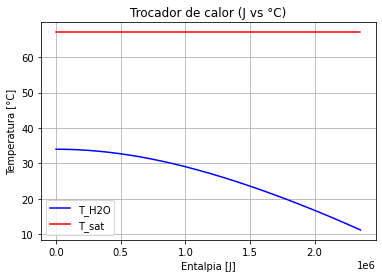

In [264]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.plot(sol.y[0], sol.y[1], 'b', label='T_H2O')
ax1.plot(sol.y[0], 200*[T_sat], 'r', label='T_sat')
# Adicionando texto nos eixos - descrição
ax1.set_xlabel('Entalpia [J]')
ax1.set_ylabel('Temperatura [°C]')
# Adicionando título para a figura
ax1.set_title('Trocador de calor (J vs °C)')
# Adicionando uma legenda
ax1.legend()
ax1.grid()
#Fria no sentido negativo de X:

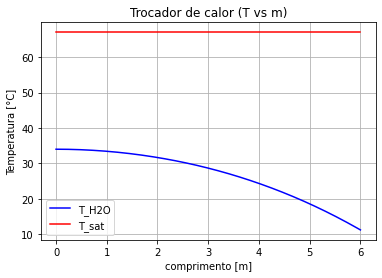

In [265]:
fig1, ax1 = plt.subplots()
ax1.plot(sol.t, sol.y[1], 'b', label='T_H2O')
ax1.plot(sol.t, 200*[T_sat], 'r', label='T_sat')
# Adicionando texto nos eixos - descrição
ax1.set_xlabel('comprimento [m]')
ax1.set_ylabel('Temperatura [°C]')
# Adicionando título para a figura
ax1.set_title('Trocador de calor (T vs m)')
# Adicionando uma legenda
ax1.legend()
ax1.grid()
#sentido contrário de x para corrente gelada